In [1]:
pip install notebook jupyter yfinance pandas numpy matplotlib PyPortfolioOpt


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     - ------------------------------------- 41.0/949.2 kB 1.9 MB/s eta 0:00:01
     --- ----------------------------------- 92.2/949.2 kB 1.7 MB/s eta 0:00:01
     --------- ---------------------------- 225.3/949.2 kB 2.3 MB/s eta 0:00:01
     ------------------- ------------------ 481.3/949.2 kB 3.0 MB/s eta 0:00:01
     ------------------------------ ------- 768.0/949.2 kB 3.7 MB/s eta 0:00:01
     ------------------------------------ - 921.6/949.2 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 949.2/949.2 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies: star


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\tqtoa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt

# default chart size
plt.rcParams["figure.figsize"] = (8, 5)

# Project directories (relative to repo root)
DATA_DIR = Path("data")
FIG_DIR = Path("figs")
DATA_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

print("Folders ready:", DATA_DIR.resolve(), FIG_DIR.resolve())


Folders ready: C:\Users\tqtoa\finance-portfolio-optimization\notebooks\notebooks\data C:\Users\tqtoa\finance-portfolio-optimization\notebooks\notebooks\figs


In [5]:
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "JPM", "TSLA"]  # tech + bank
start = "2019-01-01"  # ~5+ years
end = None            # up to today

# Adjusted close is best for return calculations (dividends/splits handled)
raw = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

# If yfinance returns a multiindex, select 'Close'
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"].copy()
else:
    prices = raw.copy()

print(prices.shape)
prices.tail()


(1670, 6)


Ticker,AAPL,AMZN,JPM,MSFT,NVDA,TSLA
Date,,,,,,
2025-08-18,230.889999,231.490005,291.529999,516.251282,182.009995,335.160004
2025-08-19,230.559998,228.009995,290.660004,508.933350,175.639999,329.309998
2025-08-20,226.009995,223.809998,292.239990,504.890015,175.399994,323.899994
2025-08-21,224.899994,221.949997,291.470001,504.239990,174.979996,320.109985
2025-08-22,228.160004,228.440002,295.549988,508.230011,178.184998,338.473206


In [7]:
# Data quality checks
assert prices.notna().sum().min() > 500, "Data too sparse—try different dates/tickers."
assert (prices.index.is_monotonic_increasing), "Index not sorted!"
display(prices.isna().sum().to_frame("NA_count"))

# Cache to CSV 
prices.to_csv(DATA_DIR / "prices_adjclose.csv")
print("Saved:", (DATA_DIR / "prices_adjclose.csv").resolve())


,NA_count
Ticker,
AAPL,0
AMZN,0
JPM,0
MSFT,0
NVDA,0
TSLA,0


Saved: C:\Users\tqtoa\finance-portfolio-optimization\notebooks\notebooks\data\prices_adjclose.csv


In [8]:
returns = np.log(prices / prices.shift(1)).dropna()

summary = pd.DataFrame({
    "mean_daily_return": returns.mean(),
    "vol_daily": returns.std(),
    "mean_annual_return": returns.mean() * 252,
    "vol_annual": returns.std() * np.sqrt(252),
})
summary.sort_values("mean_annual_return", ascending=False)


,mean_daily_return,vol_daily,mean_annual_return,vol_annual
Ticker,,,,
NVDA,0.002376,0.032807,0.598772,0.520788
TSLA,0.001675,0.040938,0.422094,0.649866
AAPL,0.001081,0.019856,0.272339,0.315202
MSFT,0.001006,0.018154,0.253551,0.288186
JPM,0.000768,0.019062,0.193560,0.302594
AMZN,0.000652,0.021631,0.164281,0.343386


In [10]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

# Expected returns (annualized) & robust covariance
mu = mean_historical_return(prices)
S = CovarianceShrinkage(prices).ledoit_wolf()

# Efficient Frontier — Max Sharpe with tiny L2 regularization (prevents extreme weights)
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.001)
weights = ef.max_sharpe()
clean_w = ef.clean_weights()

ret, vol, sharpe = ef.portfolio_performance()
print(f"Max Sharpe portfolio -> Return: {ret:.2%}, Vol: {vol:.2%}, Sharpe: {sharpe:.2f}")
pd.Series(clean_w, name="weight").sort_values(ascending=False)


Max Sharpe portfolio -> Return: 70.44%, Vol: 44.57%, Sharpe: 1.58


C:\Users\tqtoa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


NVDA    0.78809
JPM     0.14250
AAPL    0.04076
TSLA    0.02865
AMZN    0.00000
MSFT    0.00000
Name: weight, dtype: float64

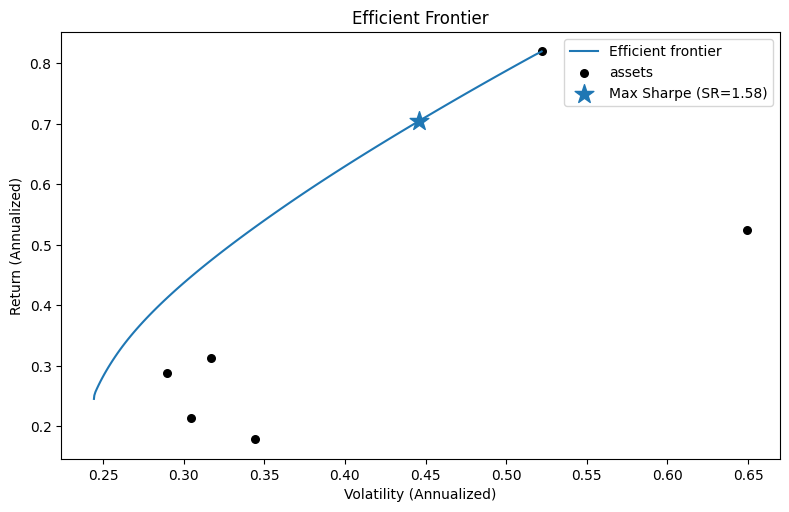

Saved figure: C:\Users\tqtoa\finance-portfolio-optimization\notebooks\notebooks\figs\efficient_frontier.png


In [11]:
from pypfopt import plotting

ef_plot = EfficientFrontier(mu, S)  # fresh instance for plotting
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark our Max Sharpe point
ax.scatter(vol, ret, marker="*", s=200, label=f"Max Sharpe (SR={sharpe:.2f})")
ax.set_title("Efficient Frontier")
ax.set_xlabel("Volatility (Annualized)")
ax.set_ylabel("Return (Annualized)")
ax.legend()
plt.show()

fig.savefig(FIG_DIR / "efficient_frontier.png", bbox_inches="tight")
print("Saved figure:", (FIG_DIR / "efficient_frontier.png").resolve())


In [12]:
# Equal-weight portfolio performance (same universe)
equal_w = np.array([1/len(tickers)] * len(tickers))

# Compute annualized return/volatility for any weight vector
def portfolio_perf(weights, mu_vec, cov_mat):
    ann_ret = float(np.dot(weights, mu_vec))
    ann_vol = float(np.sqrt(np.dot(weights, np.dot(cov_mat, weights))))
    return ann_ret, ann_vol

w_opt = np.array([clean_w[t] for t in tickers])
ret_eq, vol_eq = portfolio_perf(equal_w, mu.values, S.values)
ret_opt, vol_opt = portfolio_perf(w_opt, mu.values, S.values)

impr_ret = (ret_opt - ret_eq) / abs(ret_eq) * 100
reduct_vol = (vol_eq - vol_opt) / vol_eq * 100

print(f"Equal-weight -> Return: {ret_eq:.2%}, Vol: {vol_eq:.2%}")
print(f"Optimized    -> Return: {ret_opt:.2%}, Vol: {vol_opt:.2%}, Sharpe ~ {ret_opt/vol_opt:.2f}")
print(f"Δ Return vs equal-weight: {impr_ret:.1f}% | Volatility reduction: {reduct_vol:.1f}%")


Equal-weight -> Return: 38.98%, Vol: 30.72%
Optimized    -> Return: 31.29%, Vol: 28.98%, Sharpe ~ 1.08
Δ Return vs equal-weight: -19.7% | Volatility reduction: 5.7%


In [13]:
weights_path = DATA_DIR / "optimal_weights.csv"
perf_path = DATA_DIR / "performance.txt"

pd.Series(clean_w, name="weight").to_csv(weights_path)

with open(perf_path, "w") as f:
    f.write(f"Max Sharpe Portfolio\n")
    f.write(f"Return: {ret_opt:.4%}\n")
    f.write(f"Volatility: {vol_opt:.4%}\n")
    f.write(f"Sharpe (approx): {ret_opt/vol_opt:.2f}\n")
    f.write(f"Equal-weight Return: {ret_eq:.4%}\n")
    f.write(f"Equal-weight Volatility: {vol_eq:.4%}\n")

weights_path, perf_path


(WindowsPath('data/optimal_weights.csv'), WindowsPath('data/performance.txt'))